### TP Nº3
Alumna: Lara Rosenberg

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


En este caso, vamos a utilizar un modelo many to many donde las unidades van a ser palabras a traves de redes recurrentes.

In [1]:
# Importamos las librerias necesarias
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import urllib.request
import bs4 as bs

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import pad_sequences

import re

In [2]:
!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.4 MB/s eta 0:00:00


In [3]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 9.9 MB/s eta 0:00:00


### Datos
Tomaré como dataset el libro de Orgullo y prejuicio, de Jane Austen

In [4]:
raw_html = urllib.request.urlopen('https://www.textos.info/jane-austen/orgullo-y-prejuicio/ebook')
raw_html = raw_html.read()
# Parseamos artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')
# Encontramos todos los párrafos del HTML (bajo el tag)
article_paragraphs = article_html.find_all('p')
# Observamos los primeros 10 parrafos
article_paragraphs[:10]

[<p><a class="hidden-xs text-cover-thumb" href="./jane-austen/orgullo-y-prejuicio"><img alt="Orgullo y Prejuicio, de Jane Austen" class="img-thumbnail img-responsive pull-right" height="180" src="./img/8/t8256/jane-austen/orgullo-y-prejuicio.jpg" width="120"/></a></p>,
 <p>Es una verdad mundialmente reconocida que un hombre soltero, poseedor de una gran fortuna, necesita una esposa.</p>,
 <p>Sin embargo, poco se sabe de los sentimientos u opiniones de un 
 hombre de tales condiciones cuando entra a formar parte de un 
 vecindario. Esta verdad está tan arraigada en las mentes de algunas de 
 las familias que lo rodean, que algunas le consideran de su legítima 
 propiedad y otras de la de sus hijas.</p>,
 <p>—Mi querido señor Bennet —le dijo un día su esposa—, ¿sabías que, por fin, se ha alquilado Netherfield Park?</p>,
 <p>El señor Bennet respondió que no.</p>,
 <p>—Pues así es —insistió ella—; la señora Long ha estado aquí hace un momento y me lo ha contado todo.</p>,
 <p>El señor Benn

In [5]:
from unidecode import unidecode
# Función de limpieza
def clean_text(text):
    # Convertimos el texto a minuscula
    text = text.lower()
    # Reemplazamos los saltos de linea
    text = text.replace('\r', ' ').replace('\n', ' ')
    # Eliminamos los guiones y los punto y coma
    text = text.replace('—', '')
    text = text.replace(';', '')
    text = text.replace('¡', '')
    text = text.replace('!', '')
    text = text.replace('¿', '')
    text = text.replace('?', '')
    text = unidecode(text)
    # Reemplazamos espacios múltiples por un solo espacio
    text = re.sub(r'\s+', ' ', text)
    # Eliminamos espacios adicionales al principio y al final del texto
    text = text.strip()
    return text

Para poder determinar el tamaño de contexto de tokens máximo que puede consumir el modelo, vemos la distribucion de cantidad de palabras (términos) en cada parrafo.

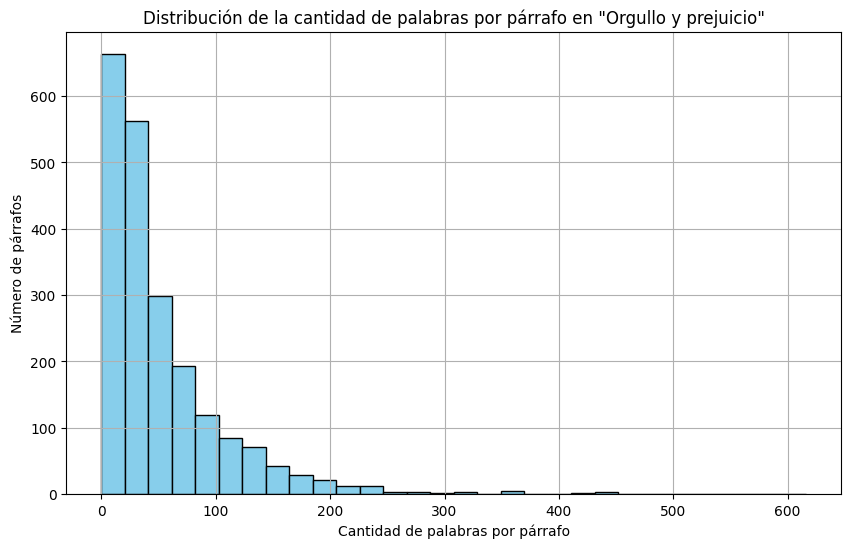

In [6]:
# Contar la cantidad de palabras por párrafo
word_counts = []
for paragraph in article_paragraphs:
    # Obtener el texto del párrafo
    text = clean_text(paragraph.get_text())

    # Dividir el texto en palabras y contar cuántas hay
    word_count = len(text.split())
    word_counts.append(word_count)

# Graficar la distribución de la cantidad de palabras por párrafo
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Cantidad de palabras por párrafo')
plt.ylabel('Número de párrafos')
plt.title('Distribución de la cantidad de palabras por párrafo en "Orgullo y prejuicio"')
plt.grid(True)
plt.show()

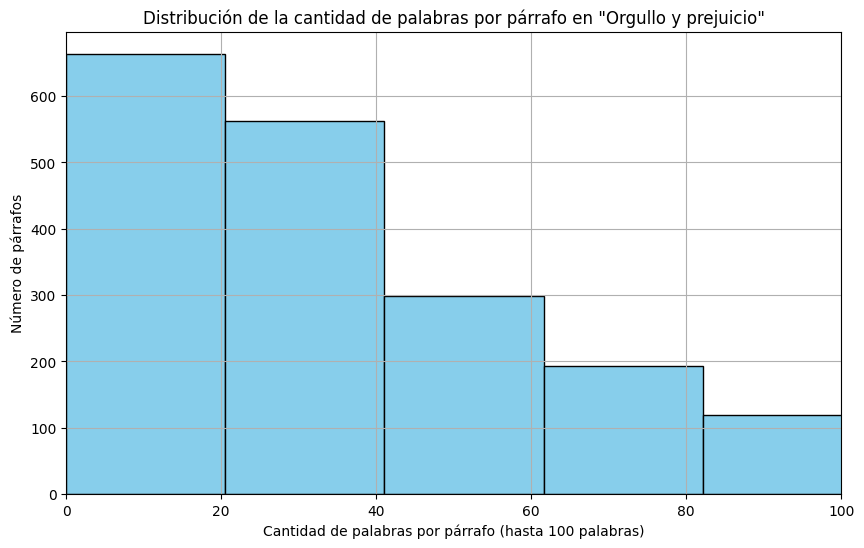

In [7]:
# Graficar la distribución de la cantidad de palabras por párrafo (todo el rango de palabras)
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=30, color='skyblue', edgecolor='black')

# Ajustar los límites del eje x para cortar la visualización a 100 palabras
plt.xlim(0, 100)

# Etiquetas y título
plt.xlabel('Cantidad de palabras por párrafo (hasta 100 palabras)')
plt.ylabel('Número de párrafos')
plt.title('Distribución de la cantidad de palabras por párrafo en "Orgullo y prejuicio"')
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [8]:
max_context_size = int(np.percentile(word_counts, 50)-1)
max_context_size

33

In [9]:
# Filtramos párrafos vacíos, limpiamos el texto y lo segmentamos
segmented_paragraph = []
paragraph_clean = []
for paragraph in article_paragraphs:
    # Limpiar el texto del párrafo
    cleaned_text = clean_text(paragraph.get_text())

    # Solo segmentar si el párrafo no está vacío
    if cleaned_text.strip():  # Verifica que el texto no sea solo espacios en blanco
        # Segmentar el párrafo limpio en palabras
        paragraph_clean.append(cleaned_text)
        segmented_paragraph.append(text_to_word_sequence(cleaned_text))

# Mostramos los primeros párrafos limpios y los segmentados
print(paragraph_clean[:5])
print(segmented_paragraph[:5])

['es una verdad mundialmente reconocida que un hombre soltero, poseedor de una gran fortuna, necesita una esposa.', 'sin embargo, poco se sabe de los sentimientos u opiniones de un hombre de tales condiciones cuando entra a formar parte de un vecindario. esta verdad esta tan arraigada en las mentes de algunas de las familias que lo rodean, que algunas le consideran de su legitima propiedad y otras de la de sus hijas.', 'mi querido senor bennet le dijo un dia su esposa, sabias que, por fin, se ha alquilado netherfield park', 'el senor bennet respondio que no.', 'pues asi es insistio ella la senora long ha estado aqui hace un momento y me lo ha contado todo.']
[['es', 'una', 'verdad', 'mundialmente', 'reconocida', 'que', 'un', 'hombre', 'soltero', 'poseedor', 'de', 'una', 'gran', 'fortuna', 'necesita', 'una', 'esposa'], ['sin', 'embargo', 'poco', 'se', 'sabe', 'de', 'los', 'sentimientos', 'u', 'opiniones', 'de', 'un', 'hombre', 'de', 'tales', 'condiciones', 'cuando', 'entra', 'a', 'forma

In [10]:
# Instanciamos el tokenizador
tok = Tokenizer()
tok.fit_on_texts(segmented_paragraph)
tokenized_sentences = tok.texts_to_sequences(segmented_paragraph)

In [11]:
print('primer parrafo:', segmented_paragraph[0])
print('cantidad palabras primer parrafo:', len(segmented_paragraph[0]))
print('primer token:', tokenized_sentences[0])
print('largo token:', len(tokenized_sentences[0]))

primer parrafo: ['es', 'una', 'verdad', 'mundialmente', 'reconocida', 'que', 'un', 'hombre', 'soltero', 'poseedor', 'de', 'una', 'gran', 'fortuna', 'necesita', 'una', 'esposa']
cantidad palabras primer parrafo: 17
primer token: [27, 19, 215, 5015, 3383, 1, 22, 127, 1798, 3384, 2, 19, 163, 373, 1799, 19, 387]
largo token: 17


Nos quedamos con un conjunto de datos de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad

In [12]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

In [13]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [14]:
tokenized_sentences_train[0]

[7,
 4084,
 2,
 16,
 990,
 11,
 32,
 2484,
 5,
 9595,
 210,
 6,
 14,
 2032,
 3,
 409,
 485,
 2,
 1,
 87,
 905,
 2084,
 1,
 9596,
 73,
 2,
 22,
 470,
 9597,
 100,
 76,
 34,
 117,
 106,
 493,
 1,
 261,
 4980,
 2,
 197,
 6,
 825,
 9598,
 4,
 40,
 5,
 4,
 43,
 2,
 904,
 722,
 2,
 2306,
 1767]

In [15]:
tok_sent[0]

[7,
 4084,
 2,
 16,
 990,
 11,
 32,
 2484,
 5,
 9595,
 210,
 6,
 14,
 2032,
 3,
 409,
 485,
 2,
 1,
 87,
 905,
 2084,
 1,
 9596,
 73,
 2,
 22,
 470,
 9597,
 100,
 76,
 34,
 117,
 106]

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas

In [16]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+3] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [17]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [18]:
train_seqs.shape

(1585555, 34)

Estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]
Target: secuencia de tokens [$x_1$, $x_2$, ...,$x_{N+1}$]

In [19]:
# Calculamos las entradas y salidas del modelo
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

In [20]:
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    7, 4084],
      dtype=int32)

In [21]:
y[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    7, 4084,    2],
      dtype=int32)

In [22]:
y.shape

(1585555, 33)

In [23]:
# Palabras del vocabulario
tok.index_word

{1: 'que',
 2: 'de',
 3: 'la',
 4: 'a',
 5: 'y',
 6: 'no',
 7: 'el',
 8: 'en',
 9: 'su',
 10: 'se',
 11: 'con',
 12: 'lo',
 13: 'por',
 14: 'le',
 15: 'pero',
 16: 'elizabeth',
 17: 'los',
 18: 'para',
 19: 'una',
 20: 'mas',
 21: 'las',
 22: 'un',
 23: 'al',
 24: 'me',
 25: 'habia',
 26: 'si',
 27: 'es',
 28: 'darcy',
 29: 'como',
 30: 'sus',
 31: 'senor',
 32: 'tan',
 33: 'mi',
 34: 'del',
 35: 'era',
 36: 'muy',
 37: 'bingley',
 38: 'senora',
 39: 'todo',
 40: 'ella',
 41: 'cuando',
 42: 'bennet',
 43: 'jane',
 44: 'dijo',
 45: 'estaba',
 46: 'usted',
 47: 'esta',
 48: 'wickham',
 49: 'sin',
 50: 'ser',
 51: 'senorita',
 52: 'ya',
 53: 'ni',
 54: 'ha',
 55: 'nada',
 56: 'collins',
 57: 'te',
 58: 'casa',
 59: 'yo',
 60: 'o',
 61: 'fue',
 62: 'aunque',
 63: 'tenia',
 64: 'dos',
 65: 'hermana',
 66: 'mucho',
 67: 'bien',
 68: 'lydia',
 69: 'solo',
 70: 'catherine',
 71: 'todos',
 72: 'tu',
 73: 'despues',
 74: 'nunca',
 75: 'podia',
 76: 'vez',
 77: 'les',
 78: 'pues',
 79: 'hasta',
 

In [24]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

10362

In [25]:
# El índice para cada palabra (el sistema las ordena de las más populares a las menos populares)
print(tok.word_index)

{'que': 1, 'de': 2, 'la': 3, 'a': 4, 'y': 5, 'no': 6, 'el': 7, 'en': 8, 'su': 9, 'se': 10, 'con': 11, 'lo': 12, 'por': 13, 'le': 14, 'pero': 15, 'elizabeth': 16, 'los': 17, 'para': 18, 'una': 19, 'mas': 20, 'las': 21, 'un': 22, 'al': 23, 'me': 24, 'habia': 25, 'si': 26, 'es': 27, 'darcy': 28, 'como': 29, 'sus': 30, 'senor': 31, 'tan': 32, 'mi': 33, 'del': 34, 'era': 35, 'muy': 36, 'bingley': 37, 'senora': 38, 'todo': 39, 'ella': 40, 'cuando': 41, 'bennet': 42, 'jane': 43, 'dijo': 44, 'estaba': 45, 'usted': 46, 'esta': 47, 'wickham': 48, 'sin': 49, 'ser': 50, 'senorita': 51, 'ya': 52, 'ni': 53, 'ha': 54, 'nada': 55, 'collins': 56, 'te': 57, 'casa': 58, 'yo': 59, 'o': 60, 'fue': 61, 'aunque': 62, 'tenia': 63, 'dos': 64, 'hermana': 65, 'mucho': 66, 'bien': 67, 'lydia': 68, 'solo': 69, 'catherine': 70, 'todos': 71, 'tu': 72, 'despues': 73, 'nunca': 74, 'podia': 75, 'vez': 76, 'les': 77, 'pues': 78, 'hasta': 79, 'tiempo': 80, 'habria': 81, 'poco': 82, 'porque': 83, 'este': 84, 'familia': 85

In [26]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
print(tok.word_docs)

defaultdict(<class 'int'>, {'fortuna': 30, 'una': 585, 'es': 453, 'hombre': 94, 'gran': 78, 'necesita': 5, 'reconocida': 2, 'verdad': 60, 'soltero': 4, 'que': 1659, 'esposa': 32, 'de': 1494, 'un': 564, 'mundialmente': 1, 'poseedor': 2, 'u': 5, 'a': 1262, 'los': 530, 'propiedad': 9, 'tales': 24, 'mentes': 1, 'otras': 46, 'opiniones': 9, 'las': 500, 'cuando': 302, 'parte': 90, 'sentimientos': 65, 'poco': 144, 'su': 948, 'familias': 11, 'legitima': 2, 'arraigada': 2, 'tan': 367, 'rodean': 1, 'entra': 2, 'esta': 231, 'en': 1036, 'hijas': 79, 'consideran': 2, 'y': 1301, 'se': 951, 'algunas': 28, 'la': 1262, 'sus': 417, 'le': 707, 'embargo': 47, 'sabe': 30, 'vecindario': 3, 'condiciones': 5, 'lo': 777, 'formar': 5, 'sin': 220, 'querido': 51, 'alquilado': 5, 'sabias': 1, 'bennet': 277, 'netherfield': 66, 'park': 3, 'fin': 75, 'senor': 369, 'ha': 175, 'por': 691, 'mi': 279, 'dia': 115, 'dijo': 307, 'respondio': 33, 'el': 1066, 'no': 1209, 'aqui': 39, 'long': 13, 'ella': 278, 'hace': 45, 'momen

Modelo

In [27]:
#Para definir el tamaño del embedding
vocab_size**(1/4)

10.089296776511445

In [28]:
model = Sequential()


model.add(Embedding(input_dim=vocab_size+1, output_dim=11, input_shape=(None,)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(25, return_sequences=True))

# Predicción de clasificación con softmax --> la salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 11)            │         113,993 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 50)            │          12,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, None, 25)            │           7,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 10363)         │         269,438 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 403,431 (1.54 MB)

 Trainable params: 403,431 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model2.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


In [30]:
history_ppl = []
hist = model.fit(X, y, epochs=2, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=1000)

Epoch 1/2
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 5.5597

ResourceExhaustedError: Graph execution error:

Detected at node sequential_1/dense_1/Softmax defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-30-f7ed92c5d7b8>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 360, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py", line 96, in on_epoch_end

  File "<ipython-input-29-5278b5fa65de>", line 49, in on_epoch_end

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 512, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 198, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 96, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 212, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 560, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py", line 148, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/activations/activations.py", line 158, in softmax

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py", line 570, in softmax

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 88, in softmax

OOM when allocating tensor with shape[32,33,10363] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1/dense_1/Softmax}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_data_distributed_13639]

Estructurando el problema de aprendizaje como *many-to-one*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]
Target: secuencia de tokens [$x_{N+1}$]

In [ ]:
# Calculamos las entradas del modelo
X = train_seqs[:,:-1]
y = train_seqs[:,-1]

In [ ]:
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    7, 4084],
      dtype=int32)

In [ ]:
y[0]

2

In [ ]:
y.shape

(1585555,)

In [ ]:
# Palabras del vocabulario
tok.index_word

{1: 'que',
 2: 'de',
 3: 'la',
 4: 'a',
 5: 'y',
 6: 'no',
 7: 'el',
 8: 'en',
 9: 'su',
 10: 'se',
 11: 'con',
 12: 'lo',
 13: 'por',
 14: 'le',
 15: 'pero',
 16: 'elizabeth',
 17: 'los',
 18: 'para',
 19: 'una',
 20: 'mas',
 21: 'las',
 22: 'un',
 23: 'al',
 24: 'me',
 25: 'habia',
 26: 'si',
 27: 'es',
 28: 'darcy',
 29: 'como',
 30: 'sus',
 31: 'senor',
 32: 'tan',
 33: 'mi',
 34: 'del',
 35: 'era',
 36: 'muy',
 37: 'bingley',
 38: 'senora',
 39: 'todo',
 40: 'ella',
 41: 'cuando',
 42: 'bennet',
 43: 'jane',
 44: 'dijo',
 45: 'estaba',
 46: 'usted',
 47: 'esta',
 48: 'wickham',
 49: 'sin',
 50: 'ser',
 51: 'senorita',
 52: 'ya',
 53: 'ni',
 54: 'ha',
 55: 'nada',
 56: 'collins',
 57: 'te',
 58: 'casa',
 59: 'yo',
 60: 'o',
 61: 'fue',
 62: 'aunque',
 63: 'tenia',
 64: 'dos',
 65: 'hermana',
 66: 'mucho',
 67: 'bien',
 68: 'lydia',
 69: 'solo',
 70: 'catherine',
 71: 'todos',
 72: 'tu',
 73: 'despues',
 74: 'nunca',
 75: 'podia',
 76: 'vez',
 77: 'les',
 78: 'pues',
 79: 'hasta',
 

In [ ]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

10362

In [ ]:
# El índice para cada palabra (el sistema las ordena de las más populares a las menos populares)
print(tok.word_index)

{'que': 1, 'de': 2, 'la': 3, 'a': 4, 'y': 5, 'no': 6, 'el': 7, 'en': 8, 'su': 9, 'se': 10, 'con': 11, 'lo': 12, 'por': 13, 'le': 14, 'pero': 15, 'elizabeth': 16, 'los': 17, 'para': 18, 'una': 19, 'mas': 20, 'las': 21, 'un': 22, 'al': 23, 'me': 24, 'habia': 25, 'si': 26, 'es': 27, 'darcy': 28, 'como': 29, 'sus': 30, 'senor': 31, 'tan': 32, 'mi': 33, 'del': 34, 'era': 35, 'muy': 36, 'bingley': 37, 'senora': 38, 'todo': 39, 'ella': 40, 'cuando': 41, 'bennet': 42, 'jane': 43, 'dijo': 44, 'estaba': 45, 'usted': 46, 'esta': 47, 'wickham': 48, 'sin': 49, 'ser': 50, 'senorita': 51, 'ya': 52, 'ni': 53, 'ha': 54, 'nada': 55, 'collins': 56, 'te': 57, 'casa': 58, 'yo': 59, 'o': 60, 'fue': 61, 'aunque': 62, 'tenia': 63, 'dos': 64, 'hermana': 65, 'mucho': 66, 'bien': 67, 'lydia': 68, 'solo': 69, 'catherine': 70, 'todos': 71, 'tu': 72, 'despues': 73, 'nunca': 74, 'podia': 75, 'vez': 76, 'les': 77, 'pues': 78, 'hasta': 79, 'tiempo': 80, 'habria': 81, 'poco': 82, 'porque': 83, 'este': 84, 'familia': 85

In [ ]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
print(tok.word_docs)

defaultdict(<class 'int'>, {'de': 1494, 'necesita': 5, 'mundialmente': 1, 'un': 564, 'hombre': 94, 'gran': 78, 'una': 585, 'es': 453, 'poseedor': 2, 'que': 1659, 'soltero': 4, 'fortuna': 30, 'reconocida': 2, 'esposa': 32, 'verdad': 60, 'embargo': 47, 'tan': 367, 'mentes': 1, 'a': 1262, 'u': 5, 'familias': 11, 'vecindario': 3, 'sin': 220, 'entra': 2, 'lo': 777, 'consideran': 2, 'esta': 231, 'poco': 144, 'condiciones': 5, 'formar': 5, 'las': 500, 'arraigada': 2, 'y': 1301, 'sus': 417, 'algunas': 28, 'la': 1262, 'sentimientos': 65, 'cuando': 302, 'opiniones': 9, 'los': 530, 'propiedad': 9, 'hijas': 79, 'sabe': 30, 'se': 951, 'en': 1036, 'parte': 90, 'legitima': 2, 'otras': 46, 'su': 948, 'tales': 24, 'rodean': 1, 'le': 707, 'alquilado': 5, 'senor': 369, 'querido': 51, 'dia': 115, 'fin': 75, 'park': 3, 'mi': 279, 'bennet': 277, 'por': 691, 'dijo': 307, 'netherfield': 66, 'ha': 175, 'sabias': 1, 'no': 1209, 'el': 1066, 'respondio': 33, 'momento': 68, 'long': 13, 'pues': 152, 'asi': 137, 'es


### Definir el modelo

In [ ]:
#Para definir el tamaño del embedding
vocab_size**(1/4)

10.089296776511445

In [ ]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size+1, output_dim=11, input_shape=(max_context_size,)))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(75))

# Predicción de clasificación con softmax --> la salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))

model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 33, 11)              │         113,993 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 33, 100)             │          44,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 75)                  │          52,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10363)               │         787,588 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 999,181 (3.81 MB)

 Trainable params: 999,181 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

### Entrenamiento

In [ ]:
history_ppl = []
hist = model.fit(X, y, epochs=10, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=100)

Epoch 1/10
15851/15856 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.5599
 mean perplexity: 810.8131868309397 

Saved new model!
15856/15856 ━━━━━━━━━━━━━━━━━━━━ 125s 8ms/step - loss: 6.5598
Epoch 2/10
15855/15856 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9281
 mean perplexity: 720.1005253524553 

Saved new model!
15856/15856 ━━━━━━━━━━━━━━━━━━━━ 136s 7ms/step - loss: 5.9281
Epoch 3/10
15849/15856 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.5172
 mean perplexity: 785.3327108431363 

15856/15856 ━━━━━━━━━━━━━━━━━━━━ 141s 7ms/step - loss: 5.5171
Epoch 4/10
15856/15856 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.2284
 mean perplexity: 971.4701486245757 

15856/15856 ━━━━━━━━━━━━━━━━━━━━ 143s 7ms/step - loss: 5.2284
Epoch 5/10
15852/15856 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0357
 mean perplexity: 1371.4360625706236 

15856/15856 ━━━━━━━━━━━━━━━━━━━━ 143s 7ms/step - loss: 5.0357
Epoch 6/10
15853/15856 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8859
 mean perplexity: 3079.19152732267 

15

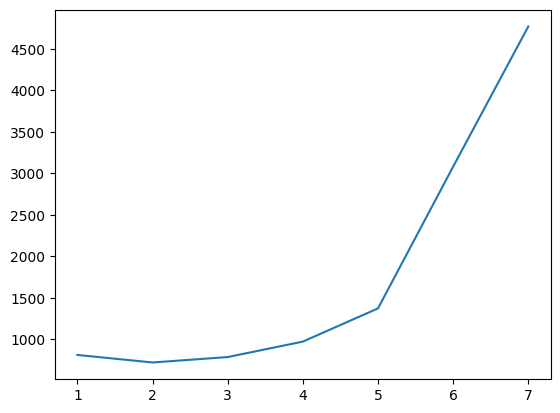

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [ ]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')


### Predicción de próxima palabra

In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8bbdb25fa0a5b13f97.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://8bbdb25fa0a5b13f97.gradio.live


### Generación de secuencias

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [ ]:
input_text='ayer fui a mi casa'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


'ayer fui a mi casa y no se habia sido que no se habia sido'

###  Beam search y muestreo aleatorio

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [ ]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=8,input="mañana voy a",temp=1,mode='sto')

In [ ]:
# veamos las salidas
decode(salidas[0])

['voy a que la senora bennet no estaba aquel familia']

In [ ]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=8,input="mañana voy a",temp=1,mode='det')

In [ ]:
# veamos las salidas
decode(salidas[0])

['voy a que la senora bennet es el senor bingley']

In [ ]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=8,input="mañana voy a",temp=2,mode='sto')
# veamos las salidas
decode(salidas[0])

['voy a magnitud a alguien y la todo asombrada estatico']